In [21]:
from generate_mdps import generate_datsets
from dataset import MDPDataset, AllNodeFeatures, InMemoryMDPDataset, TransitionsOnEdge
from experiment import Experiment
from MDP_helpers import calculate_gap, multiclass_recall_score

In [22]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCN, GAT
from torch.utils.data import random_split
from collections import defaultdict
from sklearn.metrics import recall_score, accuracy_score

from time import time
from tqdm import tqdm

In [23]:
torch.cuda.manual_seed(12345)
np.random.seed(12345)

In [24]:
# Configs
experiment_name = "GAT_weighted"
hparam_file = "hparams"
ascending = True
edge_attributes = True
gnn_model = GAT
pre_transform = TransitionsOnEdge()
N_datasets = 100

N_epochs = 3000
N_epochs_H = 1500
lr = 0.001
lr_H = 0.0001

N_sites = 6
N_species = 20
K = 8
N_states = 3**N_sites

dataset_folder = f"Reserve_MDP_{N_states}_{K}"

training_configs = {
    "Re-create data": False,
    "N_trials": 5
}

filename = f'Reserve_MDP_{N_states}_{K}'

In [25]:
# Get device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using Device: {device}")

Using Device: cuda


In [26]:
os.mkdir(f"Results/{experiment_name}") if not os.path.isdir(f"Results/{experiment_name}") else ...

In [27]:
# folder_exists = os.path.isdir(f"Results/{experiment_name}/{filename}")
# if folder_exists:
#     raise Exception("Folder exists: Experiment Exists Already!")
# else:
#     print("Creating experiment folder: Results/", experiment_name, "/", filename)
#     os.mkdir(f"Results/{experiment_name}/{filename}")

print(f"MDP Data: N_states: {N_states}")
generate_datsets(N_sites, N_species, K, N_datasets, remove_previous=training_configs["Re-create data"], folder=dataset_folder)

print("Loading data into dataloader")
print(pre_transform)
dataset = InMemoryMDPDataset(f"datasets/{dataset_folder}", pre_transform=pre_transform)
print(dataset[0])
if torch.all(dataset[0].R == dataset[5].R):
    raise Exception("Datasets are likely identical!!")

MDP Data: N_states: 729
Loading data into dataloader
Data(x=[729, 12], edges=[2, 10176], edge_features=[10176, 6], k_labels=[729], P=[6, 729, 729], R=[729, 6], V=[729], starting_probability=0.9296160928171479, random_seed=0)


In [28]:
train_ratio = 0.8
test_ratio = 0.2

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

h_param_size = int(train_ratio*train_size)
val_size = train_size - h_param_size

train_set, test_set = random_split(dataset, [train_size, test_size])
hparam_train_set, hparam_val_set = random_split(train_set, [h_param_size, val_size])

train_data = DataLoader(train_set, batch_size=1, shuffle=True)
test_data = DataLoader(test_set, batch_size=1, shuffle=True)
hparam_train_data = DataLoader(hparam_train_set, batch_size=1, shuffle=True)
hparam_val_data = DataLoader(hparam_val_set, batch_size=1, shuffle=True)

In [29]:
def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 20, 250)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0, 0.1)
    weight_decay = trial.suggest_float("weight_decay", 1e-3, 0.1)


    model = gnn_model(
        in_channels=dataset[0].x.shape[1], 
        out_channels=K, 
        hidden_channels=hidden_channels, 
        num_layers=num_layers, 
        dropout=dropout
    ).to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=lr_H, weight_decay=weight_decay)

    model.train()
    for epoch in range(N_epochs_H):
        optimizer.zero_grad()     
        loss = 0

        for data in hparam_train_data:
            if edge_attributes:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                    edge_attr=data.edge_features.to(device)
                )
            else:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                )  
            weight = torch.bincount(data.k_labels)
            weight = weight/weight.sum()
            loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))

        loss /= len(train_data) 
        loss.backward()
        optimizer.step()

        test_loss = 0
        model.eval()
        for data in hparam_val_data:
            if edge_attributes:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                    edge_attr=data.edge_features.to(device)
                )
            else:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                )  
            weight = torch.bincount(data.k_labels)
            weight = weight/weight.sum()
            test_loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))
        test_loss /= len(hparam_val_data)
    return test_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params

print(study.best_value)
print(best_params)

[I 2024-01-09 17:54:20,336] A new study created in memory with name: no-name-421136f0-821f-4964-a1cd-749cad3f1c0e
[I 2024-01-09 17:56:39,353] Trial 0 finished with value: 1.0202107429504395 and parameters: {'hidden_channels': 143, 'num_layers': 1, 'dropout': 0.015971463843454693, 'weight_decay': 0.0219024838556165}. Best is trial 0 with value: 1.0202107429504395.
[I 2024-01-09 18:01:40,624] Trial 1 finished with value: 1.8985769748687744 and parameters: {'hidden_channels': 143, 'num_layers': 4, 'dropout': 0.06543824312732839, 'weight_decay': 0.06489349810766278}. Best is trial 0 with value: 1.0202107429504395.
[I 2024-01-09 18:03:56,080] Trial 2 finished with value: 1.2240267992019653 and parameters: {'hidden_channels': 141, 'num_layers': 1, 'dropout': 0.04818795126421364, 'weight_decay': 0.050436511222629224}. Best is trial 0 with value: 1.0202107429504395.
[I 2024-01-09 18:08:02,966] Trial 3 finished with value: 1.8251396417617798 and parameters: {'hidden_channels': 98, 'num_layers':

In [ ]:
# trials = [i for i in map(lambda x: dict([("loss", x.values[0]), ("recall", x.values[1]),*(x.params).items()]), study.get_trials())]
# trials = pd.DataFrame(trials)
# trials = trials.sort_values(by='recall', ascending=False)

trials = [i for i in map(lambda x: dict([("score", x.values[0]),*(x.params).items()]), study.get_trials())]
trials = pd.DataFrame(trials)
trials = trials.sort_values(by='score', ascending=False)

experiment = Experiment(savefile=f"Results/{experiment_name}/hparams")
for i in trials.index:
    trials.loc[i].to_dict()
    experiment.save(trials.loc[i].to_dict())

In [ ]:
pd.DataFrame(experiment.load()).sort_values(by="score", ascending=True).head()

,score,hidden_channels,num_layers,dropout,weight_decay
49,0.501795,140.0,4.0,0.019882,0.001007
48,0.517946,21.0,3.0,0.052313,0.001054
47,0.529823,22.0,3.0,0.057117,0.001237
46,0.531904,175.0,4.0,0.033761,0.001167
45,0.533709,20.0,4.0,0.040401,0.001633


In [ ]:
all_results = defaultdict(lambda : defaultdict(list))
trial_name = "Trial"
trial_num = 0

hidden_channels = int(best_params['hidden_channels'])
num_layers = int(best_params['num_layers'])
dropout = best_params['dropout']
weight_decay = best_params['weight_decay']

model = gnn_model(
    in_channels=dataset[0].x.shape[1], 
    out_channels=K, 
    hidden_channels=hidden_channels, 
    num_layers=num_layers, 
    dropout=dropout
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

epochs = tqdm(range(N_epochs))
for epoch in epochs:
    model.train()
    optimizer.zero_grad()     

    loss = 0
    for data in train_data:
        if edge_attributes:
            pred = model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
                edge_attr=data.edge_features.to(device)
            )
        else:
            pred = model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
            )  
        weight = torch.bincount(data.k_labels)
        weight = weight/weight.sum()
        loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))

    loss /= len(train_data) 
    loss.backward()
    optimizer.step()

    all_results[trial_name]['training_loss'].append(loss.to('cpu').detach().float())


    model.eval()
    test_loss = 0
    avg_gap = 0
    avg_error = 0
    avg_recall = 0
    avg_acc = 0
    for data in test_data:
        if edge_attributes:
            pred = model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
                edge_attr=data.edge_features.to(device)
            )
        else:
            pred = model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
            )  
        pred_k = F.softmax(pred, dim=1).argmax(axis=1)
        weight = torch.bincount(data.k_labels)
        weight = weight/weight.sum()
        test_loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))
        gap, error = calculate_gap(data.P, data.R, data.V, pred_k, K, device='cpu')
        avg_gap += gap
        avg_error += error
        avg_recall += recall_score(data.k_labels, pred_k.to('cpu'), average="macro")
        avg_acc += accuracy_score(data.k_labels, pred_k.to('cpu'))


    test_loss /= len(test_data)
    avg_gap /= len(test_data)
    avg_error /= len(test_data)
    avg_recall /= len(test_data)
    avg_acc /= len(test_data)

    all_results[trial_name]['test_loss'].append(test_loss.to('cpu').detach().float())
    all_results[trial_name]['test_gap'].append(avg_gap)
    all_results[trial_name]['test_error'].append(avg_error)
    all_results[trial_name]['test_recall'].append(avg_recall)
    all_results[trial_name]['test_accuracy'].append(avg_acc)

    epochs.set_description(f"Trial {trial_num}, Epoch {epoch+1}/{N_epochs}, Loss {test_loss:.4f}, Gap {avg_gap:.4f}, Recall {avg_recall:.4f}, Accuracy {avg_acc:.4f}")

  0%|          | 0/3000 [00:00<?, ?it/s]/home/james/Repo/MDP-State-Abstraction-CSIRO/Approach_new/state_variables/MDP_helpers.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  Q[:, a] = R[:, a].T + gamma*T[a, :, :]@V
Trial 0, Epoch 3000/3000, Loss 0.6371, Gap 0.2688, Recall 0.6092, Accuracy 0.7224: 100%|██████████| 3000/3000 [1:11:20<00:00,  1.43s/it]


In [ ]:
# all_results.pop("trial_0");    

In [ ]:
processed = {}
for key in all_results["Trial"].keys():
    df = pd.DataFrame({trial_id:all_results[trial_id][key] for trial_id in all_results.keys()}).astype(float)
    df.to_csv(f"Results/{experiment_name}/{key}.csv")
    processed[key] = df

Generating plots


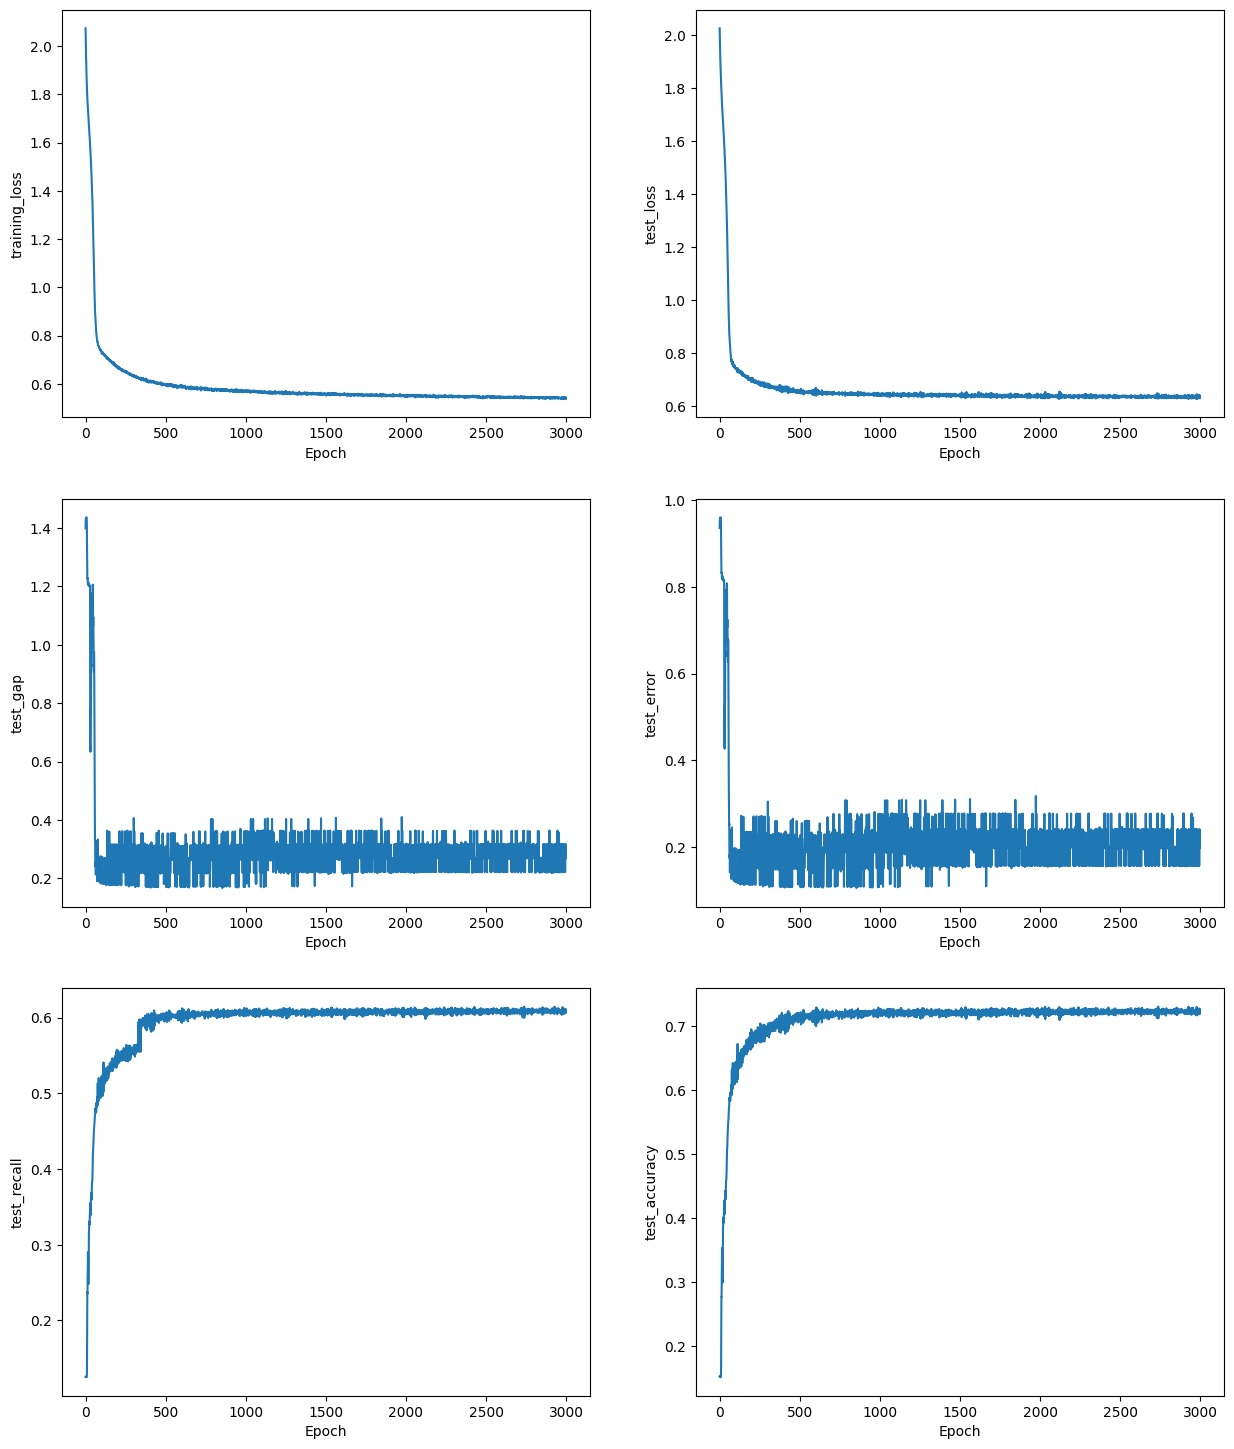

In [ ]:
processed = {}
for key in all_results["Trial"].keys():
    df = pd.DataFrame({trial_id:all_results[trial_id][key] for trial_id in all_results.keys()}).astype(float)
    # df.to_csv(f"Results/{experiment_name}/{filename}/{key}.csv")
    processed[key] = df

print("Generating plots")
n_plots = len(all_results["Trial"].keys())
n_cols = 2
n_rows = int((n_plots + n_plots%2)/2)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 6*n_rows))

count = 0
for key in all_results["Trial"].keys():
    col = count %2
    row = count //2 
    count += 1

    df_long = processed[key].stack()
    df_long.index = df_long.index.to_flat_index().map(lambda x: x[0])
    sns.lineplot(df_long, errorbar='ci', ax=ax[row, col])
    ax[row, col].set_ylabel(key)
    ax[row, col].set_xlabel("Epoch")

plt.savefig(f"Results/{experiment_name}/plots.png")

In [ ]:
processed

{'training_loss':          Trial
 0     2.074570
 1     2.030126
 2     1.992201
 3     1.961114
 4     1.929623
 ...        ...
 2995  0.545009
 2996  0.538543
 2997  0.543267
 2998  0.542235
 2999  0.537812
 
 [3000 rows x 1 columns],
 'test_loss':          Trial
 0     2.027330
 1     1.992310
 2     1.961846
 3     1.935015
 4     1.911430
 ...        ...
 2995  0.636228
 2996  0.641272
 2997  0.630940
 2998  0.641542
 2999  0.637081
 
 [3000 rows x 1 columns],
 'test_gap':          Trial
 0     1.398705
 1     1.427770
 2     1.434147
 3     1.434147
 4     1.436048
 ...        ...
 2995  0.317149
 2996  0.269166
 2997  0.270816
 2998  0.316550
 2999  0.268796
 
 [3000 rows x 1 columns],
 'test_error':          Trial
 0     0.936416
 1     0.955243
 2     0.959409
 3     0.959409
 4     0.960879
 ...        ...
 2995  0.240181
 2996  0.199566
 2997  0.197391
 2998  0.239687
 2999  0.199320
 
 [3000 rows x 1 columns],
 'test_recall':          Trial
 0     0.125643
 1     0.125647
 